
TEST 1: GAUSSIAN BLUR
Kernel Type: Gaussian, Size: 15x15, Sigma: 3.0
METHOD 1: SPATIAL DOMAIN FILTERING (CONVOLUTION)
METHOD 2: FREQUENCY DOMAIN FILTERING (MULTIPLICATION)

COMPARISON RESULTS
Maximum difference: 0.0000000000
Mean difference: 0.0000000000
Relative error: 0.0000000000
PROOF VERIFIED: Convolution in space = Multiplication in frequency!



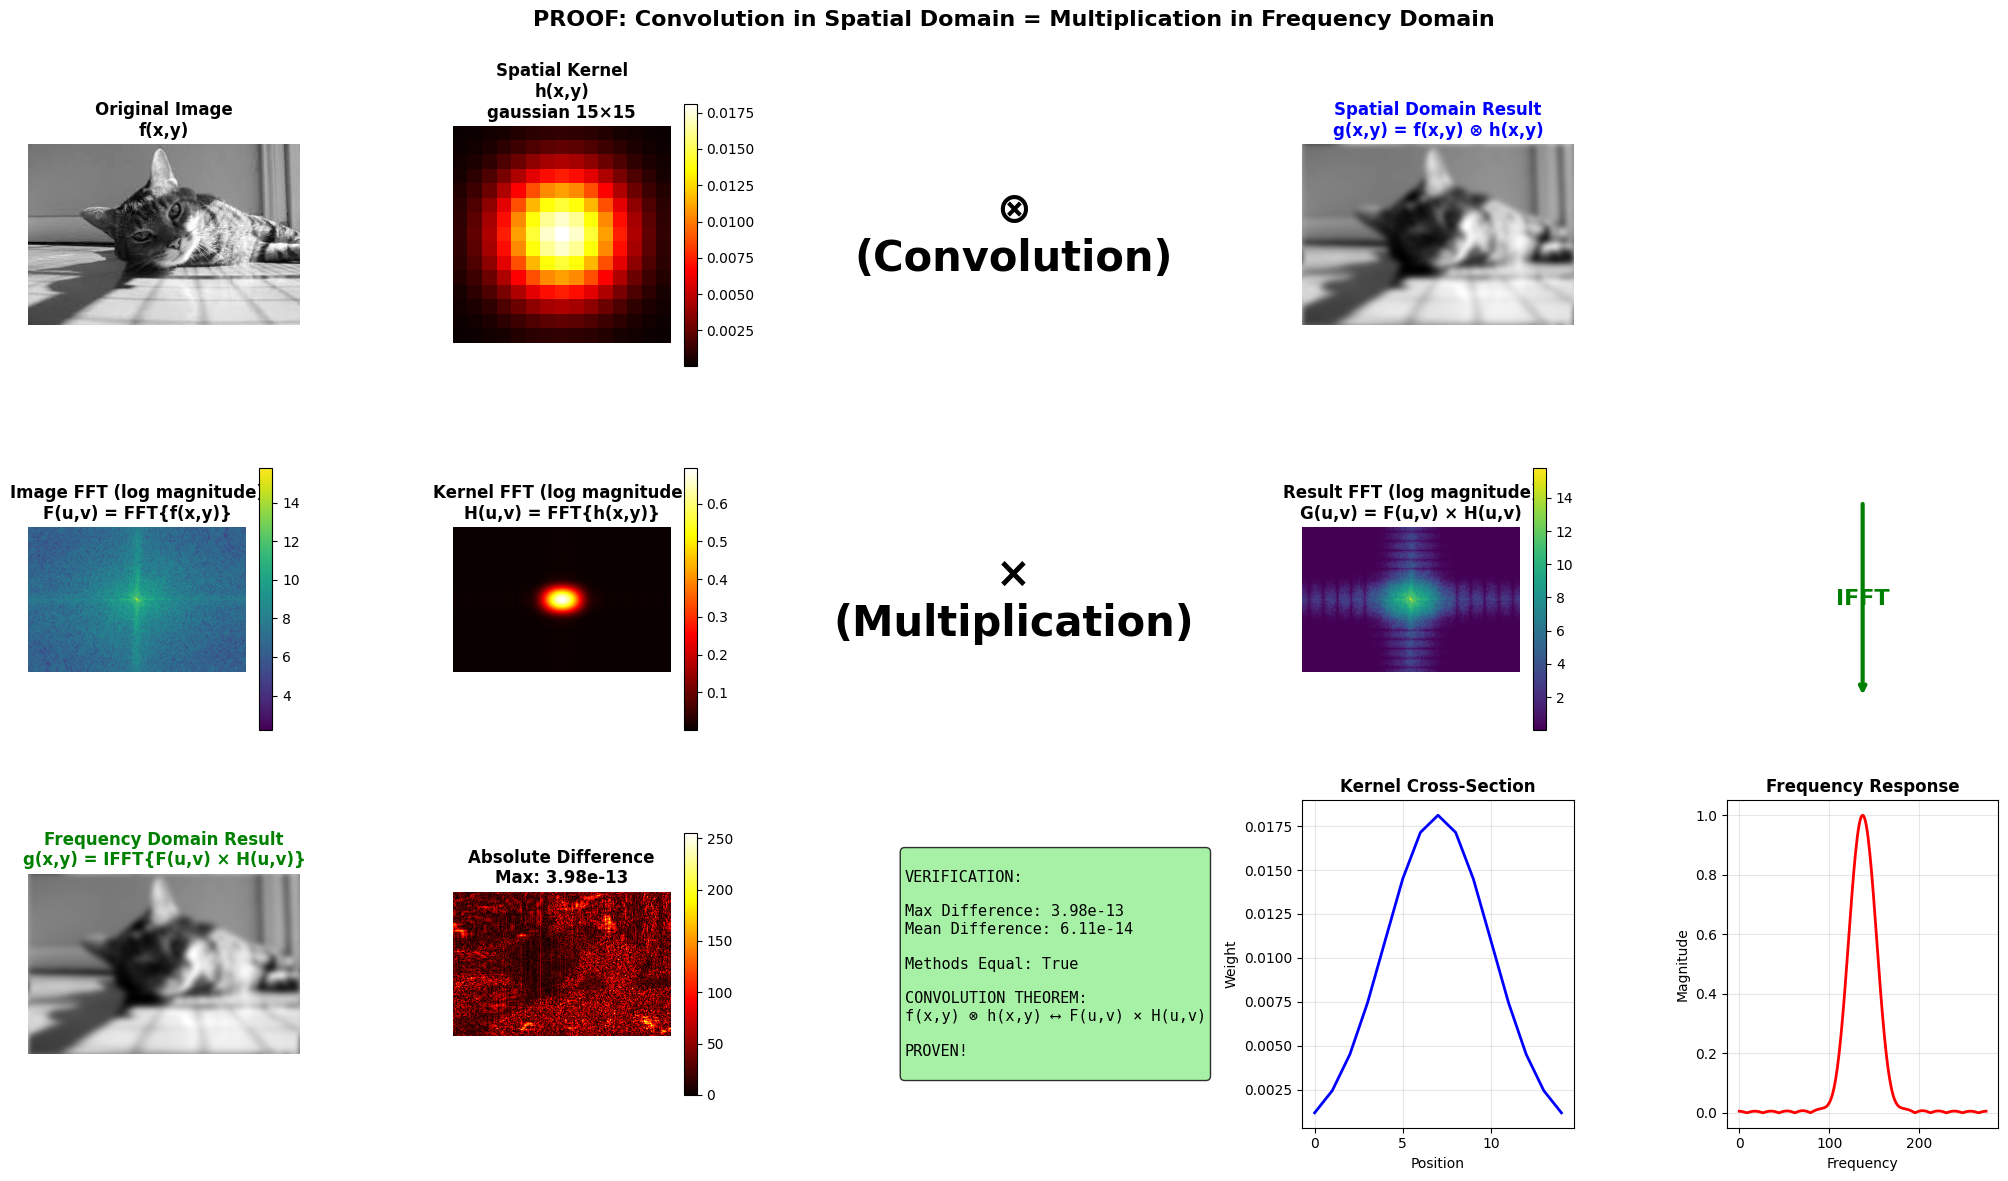


TEST 2: BOX BLUR
Kernel Type: Box, Size: 11x11
METHOD 1: SPATIAL DOMAIN FILTERING (CONVOLUTION)
METHOD 2: FREQUENCY DOMAIN FILTERING (MULTIPLICATION)

COMPARISON RESULTS
Maximum difference: 0.0000000000
Mean difference: 0.0000000000
Relative error: 0.0000000000
PROOF VERIFIED: Convolution in space = Multiplication in frequency!



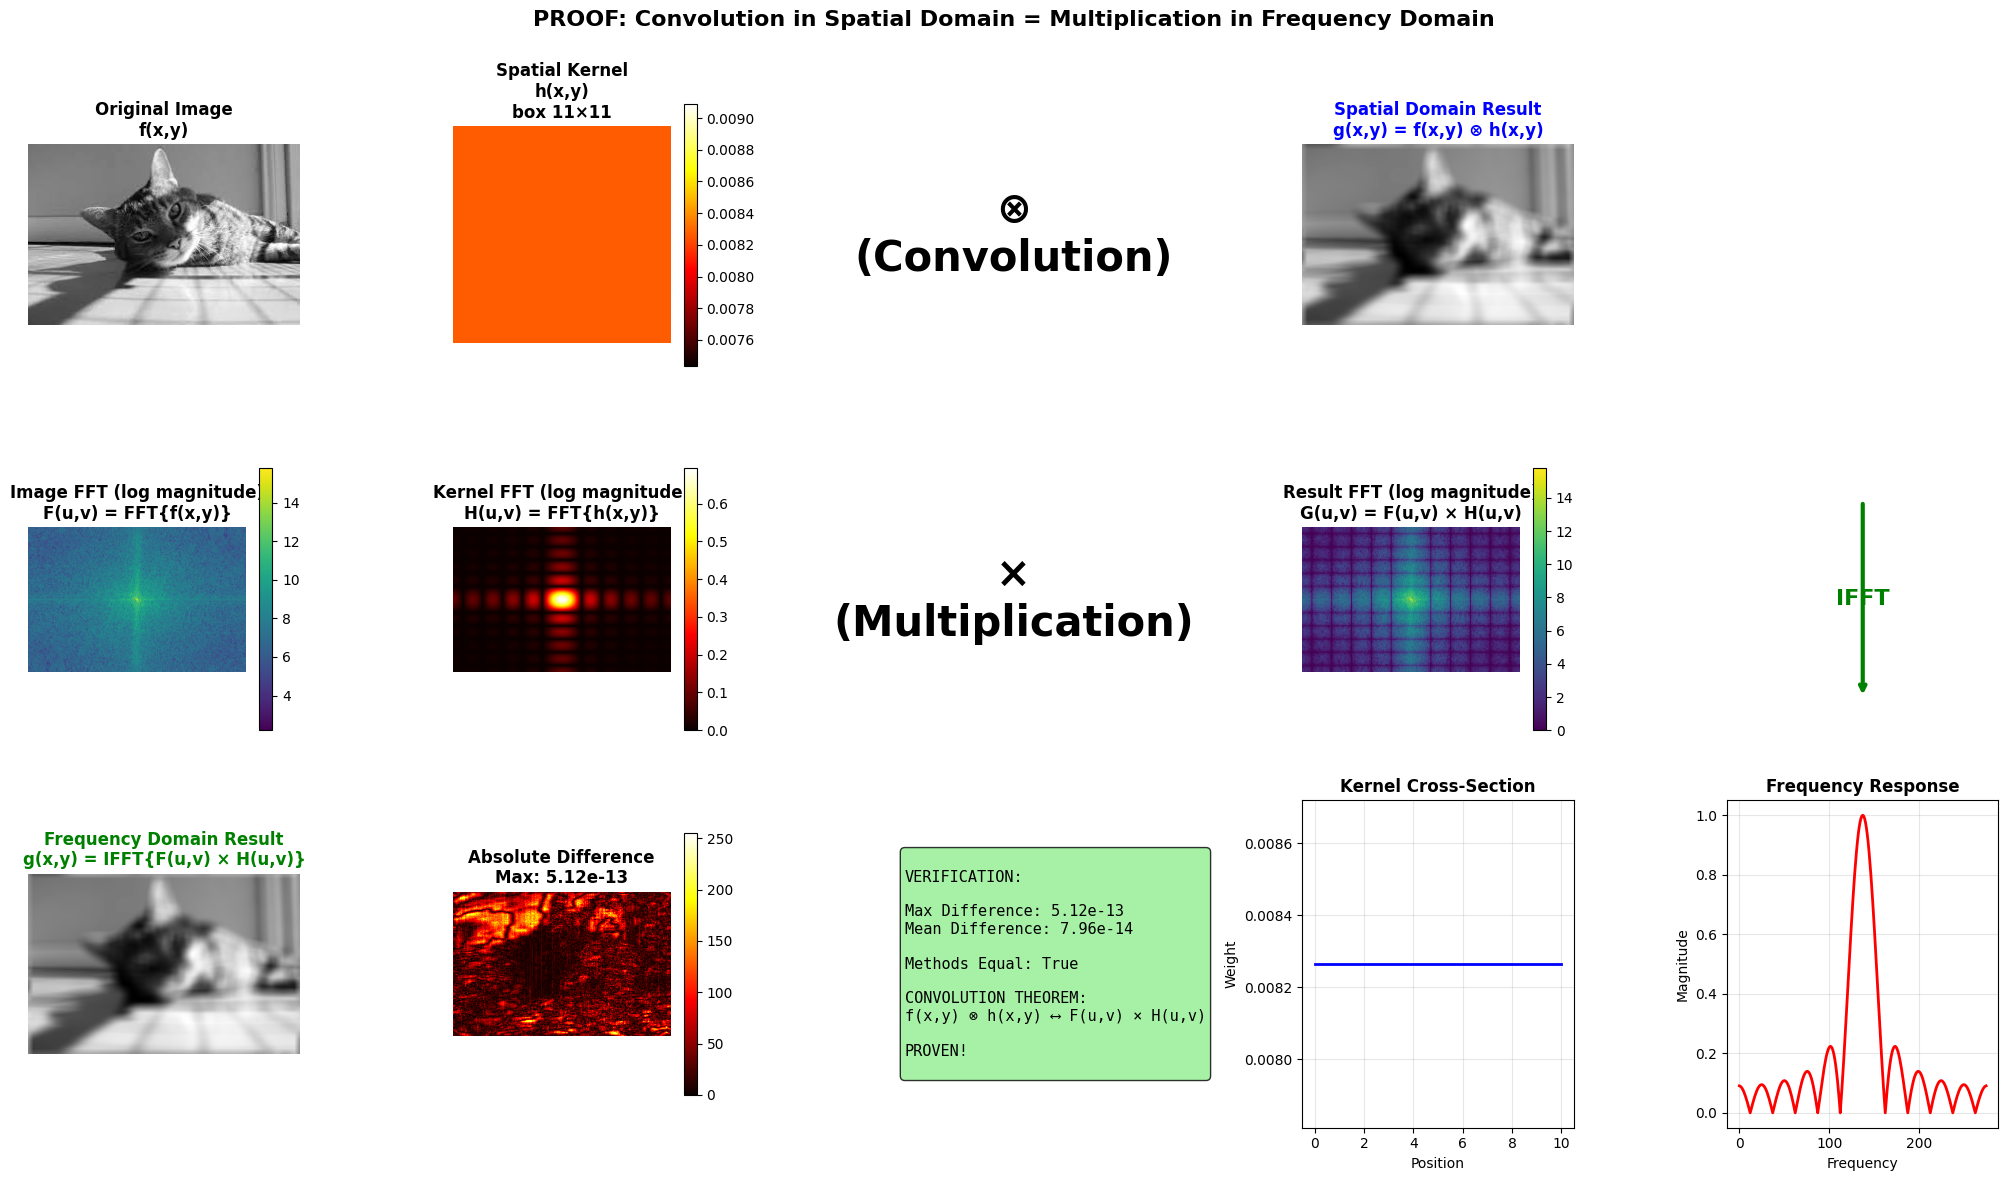

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, ndimage
import cv2

class BlurringComparison:
    
    def __init__(self, image):
        """
        Args:
            image: 2D grayscale image (H, W)
        """
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        self.image = image.astype(np.float64)
        self.H, self.W = image.shape
        
    def create_gaussian_kernel(self, kernel_size=15, sigma=3.0):
        """Create Gaussian blur kernel"""
        ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
        xx, yy = np.meshgrid(ax, ax)
        
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        kernel = kernel / np.sum(kernel)  # Normalize
        
        return kernel
    
    def create_box_kernel(self, kernel_size=15):
        """Create box/average blur kernel"""
        kernel = np.ones((kernel_size, kernel_size))
        kernel = kernel / np.sum(kernel)  # Normalize
        return kernel
    
    def spatial_filtering(self, kernel):
        """
        METHOD 1: Spatial Domain Filtering (Convolution)
        
        Formula: g(x,y) = f(x,y) ⊗ h(x,y)
        where ⊗ denotes convolution
        """
        print("METHOD 1: SPATIAL DOMAIN FILTERING (CONVOLUTION)")
        
        # Perform convolution
        blurred = signal.convolve2d(self.image, kernel, mode='same', boundary='wrap')
        
        return blurred
    
    def frequency_filtering(self, kernel):
        """
        METHOD 2: Frequency Domain Filtering (Multiplication)
        
        Steps:
        1. FFT of image: F(u,v) = FFT{f(x,y)}
        2. FFT of kernel: H(u,v) = FFT{h(x,y)}
        3. Multiply: G(u,v) = F(u,v) × H(u,v)
        4. Inverse FFT: g(x,y) = IFFT{G(u,v)}
        
        This proves: Convolution Theorem
        f(x,y) ⊗ h(x,y) ⟷ F(u,v) × H(u,v)
        """
        print("METHOD 2: FREQUENCY DOMAIN FILTERING (MULTIPLICATION)")
        
        # FIXED: Properly center the kernel first
        kh, kw = kernel.shape
        
        # Create a centered kernel in spatial domain
        padded_kernel = np.zeros_like(self.image)
        
        # Place kernel at center
        cy, cx = self.H // 2, self.W // 2
        ky, kx = kh // 2, kw // 2
        
        # Calculate placement coordinates
        y_start = cy - ky
        y_end = y_start + kh
        x_start = cx - kx
        x_end = x_start + kw
        
        padded_kernel[y_start:y_end, x_start:x_end] = kernel
        
        # Shift kernel so that center is at (0,0) for FFT
        padded_kernel = np.fft.ifftshift(padded_kernel)
        
        # Step 2: FFT of image
        F = np.fft.fft2(self.image)
        
        # Step 3: FFT of kernel
        H = np.fft.fft2(padded_kernel)
        
        # Step 4: Multiply in frequency domain
        G = F * H

        # Step 5: Inverse FFT
        blurred = np.fft.ifft2(G).real
        
        return blurred, F, H, G
    
    def compare_methods(self, kernel_type='gaussian', kernel_size=15, sigma=3.0):
        """
        Compare spatial and frequency domain filtering
        """      
        # Create kernel
        if kernel_type == 'gaussian':
            kernel = self.create_gaussian_kernel(kernel_size, sigma)
            print(f"Kernel Type: Gaussian, Size: {kernel_size}x{kernel_size}, Sigma: {sigma}")
        else:
            kernel = self.create_box_kernel(kernel_size)
            print(f"Kernel Type: Box, Size: {kernel_size}x{kernel_size}")
        
        # Method 1: Spatial domain (convolution)
        spatial_result = self.spatial_filtering(kernel)
        
        # Method 2: Frequency domain (multiplication)
        freq_result, F, H, G = self.frequency_filtering(kernel)
        
        # Calculate difference
        difference = np.abs(spatial_result - freq_result)
        max_diff = np.max(difference)
        mean_diff = np.mean(difference)
        
        print("\n" + "="*70)
        print("COMPARISON RESULTS")
        print("="*70)
        print(f"Maximum difference: {max_diff:.10f}")
        print(f"Mean difference: {mean_diff:.10f}")
        print(f"Relative error: {max_diff / (np.max(self.image) + 1e-10):.10f}")
        
        if max_diff < 1e-3:
            print("PROOF VERIFIED: Convolution in space = Multiplication in frequency!")
        else:
            print("Small numerical differences due to floating point precision")
        
        print("="*70 + "\n")
        
        return spatial_result, freq_result, difference, kernel, F, H, G
    
    def visualize_complete(self, kernel_type='gaussian', kernel_size=15, sigma=3.0):
        """
        Create comprehensive visualization showing all steps
        """
        spatial_result, freq_result, difference, kernel, F, H, G = \
            self.compare_methods(kernel_type, kernel_size, sigma)
        
        # Create figure
        fig = plt.figure(figsize=(20, 12))
        
        # Row 1: Spatial Domain
        # Original Image
        ax1 = plt.subplot(3, 5, 1)
        plt.imshow(self.image, cmap='gray')
        plt.title('Original Image\nf(x,y)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Spatial Kernel
        ax2 = plt.subplot(3, 5, 2)
        plt.imshow(kernel, cmap='hot')
        plt.title(f'Spatial Kernel\nh(x,y)\n{kernel_type} {kernel_size}×{kernel_size}', 
                 fontsize=12, fontweight='bold')
        plt.colorbar(shrink=0.8)
        plt.axis('off')
        
        # Convolution symbol
        ax3 = plt.subplot(3, 5, 3)
        ax3.text(0.5, 0.5, '⊗\n(Convolution)', 
                ha='center', va='center', fontsize=30, fontweight='bold')
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)
        ax3.axis('off')
        
        # Spatial Result
        ax4 = plt.subplot(3, 5, 4)
        plt.imshow(spatial_result, cmap='gray')
        plt.title('Spatial Domain Result\ng(x,y) = f(x,y) ⊗ h(x,y)', 
                 fontsize=12, fontweight='bold', color='blue')
        plt.axis('off')
        
        # Row 2: Frequency Domain
        # Image FFT (magnitude)
        ax5 = plt.subplot(3, 5, 6)
        magnitude_F = np.log(1 + np.abs(np.fft.fftshift(F)))
        plt.imshow(magnitude_F, cmap='viridis')
        plt.title('Image FFT (log magnitude)\nF(u,v) = FFT{f(x,y)}', 
                 fontsize=12, fontweight='bold')
        plt.colorbar(shrink=0.8)
        plt.axis('off')
        
        # Kernel FFT (magnitude)
        ax6 = plt.subplot(3, 5, 7)
        magnitude_H = np.log(1 + np.abs(np.fft.fftshift(H)))
        plt.imshow(magnitude_H, cmap='hot')
        plt.title('Kernel FFT (log magnitude)\nH(u,v) = FFT{h(x,y)}', 
                 fontsize=12, fontweight='bold')
        plt.colorbar(shrink=0.8)
        plt.axis('off')
        
        # Multiplication symbol
        ax7 = plt.subplot(3, 5, 8)
        ax7.text(0.5, 0.5, '×\n(Multiplication)', 
                ha='center', va='center', fontsize=30, fontweight='bold')
        ax7.set_xlim(0, 1)
        ax7.set_ylim(0, 1)
        ax7.axis('off')
        
        # Result FFT (magnitude)
        ax8 = plt.subplot(3, 5, 9)
        magnitude_G = np.log(1 + np.abs(np.fft.fftshift(G)))
        plt.imshow(magnitude_G, cmap='viridis')
        plt.title('Result FFT (log magnitude)\nG(u,v) = F(u,v) × H(u,v)', 
                 fontsize=12, fontweight='bold')
        plt.colorbar(shrink=0.8)
        plt.axis('off')
        
        # IFFT arrow
        ax9 = plt.subplot(3, 5, 10)
        ax9.annotate('', xy=(0.5, 0.2), xytext=(0.5, 0.8),
                    arrowprops=dict(arrowstyle='->', lw=3, color='green'))
        ax9.text(0.5, 0.5, 'IFFT', ha='center', va='center', 
                fontsize=16, fontweight='bold', color='green')
        ax9.set_xlim(0, 1)
        ax9.set_ylim(0, 1)
        ax9.axis('off')
        
        # Row 3: Comparison
        # Frequency Result
        ax10 = plt.subplot(3, 5, 11)
        plt.imshow(freq_result, cmap='gray')
        plt.title('Frequency Domain Result\ng(x,y) = IFFT{F(u,v) × H(u,v)}', 
                 fontsize=12, fontweight='bold', color='green')
        plt.axis('off')
        
        # Difference
        ax11 = plt.subplot(3, 5, 12)
        diff_display = difference.copy()
        # Scale difference for visibility
        if np.max(diff_display) > 0:
            diff_display = diff_display / np.max(diff_display) * 255
        plt.imshow(diff_display, cmap='hot')
        plt.title(f'Absolute Difference\nMax: {np.max(difference):.2e}', 
                 fontsize=12, fontweight='bold')
        plt.colorbar(shrink=0.8)
        plt.axis('off')
        
        # Statistics
        ax12 = plt.subplot(3, 5, 13)
        methods_equal = np.allclose(spatial_result, freq_result, rtol=1e-3, atol=1e-3)
        status = "PROVEN!" if methods_equal else "Check"
        
        stats_text = f"""
VERIFICATION:

Max Difference: {np.max(difference):.2e}
Mean Difference: {np.mean(difference):.2e}

Methods Equal: {methods_equal}

CONVOLUTION THEOREM:
f(x,y) ⊗ h(x,y) ⟷ F(u,v) × H(u,v)

{status}
        """
        color = 'lightgreen' if methods_equal else 'lightyellow'
        ax12.text(0.1, 0.5, stats_text, ha='left', va='center', 
                 fontsize=11, family='monospace',
                 bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
        ax12.set_xlim(0, 1)
        ax12.set_ylim(0, 1)
        ax12.axis('off')
        
        # Kernel cross-section
        ax13 = plt.subplot(3, 5, 14)
        center_row = kernel[kernel.shape[0]//2, :]
        plt.plot(center_row, 'b-', linewidth=2)
        plt.title('Kernel Cross-Section', fontsize=12, fontweight='bold')
        plt.xlabel('Position')
        plt.ylabel('Weight')
        plt.grid(True, alpha=0.3)
        
        # Frequency response
        ax14 = plt.subplot(3, 5, 15)
        H_centered = np.fft.fftshift(H)
        freq_response = np.abs(H_centered[H_centered.shape[0]//2, :])
        plt.plot(freq_response, 'r-', linewidth=2)
        plt.title('Frequency Response', fontsize=12, fontweight='bold')
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')
        plt.grid(True, alpha=0.3)
        
        plt.suptitle('PROOF: Convolution in Spatial Domain = Multiplication in Frequency Domain', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        return fig


# ==================== DEMONSTRATION WITH DIFFERENT KERNELS ====================

def demonstrate_convolution_theorem():
    """Complete demonstration with multiple kernel types"""
    
    # Load image
    test_image = cv2.imread('module3_images/image2.jpeg', cv2.IMREAD_GRAYSCALE)

    # Test 1: Gaussian Blur
    print("\n" + "="*70)
    print("TEST 1: GAUSSIAN BLUR")
    print("="*70)
    comparator = BlurringComparison(test_image)
    fig1 = comparator.visualize_complete(kernel_type='gaussian', kernel_size=15, sigma=3.0)
    plt.show()
    
    # Test 2: Box Blur
    print("\n" + "="*70)
    print("TEST 2: BOX BLUR")
    print("="*70)
    comparator2 = BlurringComparison(test_image)
    fig2 = comparator2.visualize_complete(kernel_type='box', kernel_size=11)
    plt.show()

# ==================== RUN COMPLETE DEMONSTRATION ====================

if __name__ == "__main__":
    # Run visual demonstrations
    demonstrate_convolution_theorem()